# Expense Analysis (10 Months)

This notebook analyzes personal expense transactions from `expenses.csv`. It focuses on **expenses only** (`type = DEBIT`) and uses the `amount` column with inverted sign so spend is positive.


In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)


## Load + Clean

In [34]:
from pathlib import Path

csv_path = Path("expenses.csv")

df = pd.read_csv(csv_path, encoding="utf-8-sig")

# Standardize column names (strip whitespace)
df.columns = [c.strip() for c in df.columns]

# Parse date
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Coerce amount to numeric
df["amount"] = pd.to_numeric(df["amount"], errors="coerce")

# Keep only expenses
expenses = df[df["type"].str.upper() == "DEBIT"].copy()

# Filter out internal transfers/payments
expenses = expenses[expenses["category"].astype(str).str.strip().str.lower() != "transfer/pmt"].copy()

# Spend should be positive
expenses["spend"] = -expenses["amount"]

# Derive month and year from date
expenses["year"] = expenses["date"].dt.year
expenses["month_start"] = expenses["date"].dt.to_period("M").dt.to_timestamp()

# Basic cleanup
expenses["category"] = expenses["category"].fillna("(uncategorized)").str.strip().str.lower()

# Sanity checks
print("rows (all):", len(df))
print("rows (expenses only):", len(expenses))
print("date NaT:", expenses["date"].isna().sum())
print("amount NaN:", expenses["amount"].isna().sum())

expenses.head()

rows (all): 1299
rows (expenses only): 1116
date NaT: 0
amount NaN: 0


,type,date,amount,id,name,memo,source,category,spend_type,vendor,month,year,amount_inv,spend,month_start
0,DEBIT,2025-03-01,-14.81,2.02503E+14,"GITHUB, INC.","GITHUB, INC.",cap_one_visa,business,bus - fixed,NaN,03-2025,2025,$14.81,14.81,2025-03-01
1,DEBIT,2025-03-02,-12.65,809-45080-100003027281,Point Of Sale Withdrawal,Store VancouverBCCA,beem_ch,food & bev,nec - discretionary,NaN,03-2025,2025,$12.65,12.65,2025-03-01
2,DEBIT,2025-03-02,-24.63,2025-02-20~2025-03-03~1325391,Amazon Channels,NaN,td_visa,entertainment,discretionary,NaN,03-2025,2025,$24.63,24.63,2025-03-01
3,DEBIT,2025-03-02,-6.71,2025-02-20~2025-03-03~1325381,Amazon Channels,NaN,td_visa,entertainment,discretionary,NaN,03-2025,2025,$6.71,6.71,2025-03-01
4,DEBIT,2025-03-02,-3.32,2025-02-20~2025-03-04~1824354,CITY OF VAN PAYBYPHONE,NaN,td_visa,auto/local trans,discretionary,NaN,03-2025,2025,$3.32,3.32,2025-03-01


## Overview

In [35]:
total_spend = expenses["spend"].sum()

summary = pd.DataFrame({
    "total_spend": [total_spend],
    "avg_monthly_spend": [expenses.groupby("month_start")["spend"].sum().mean()],
    "transaction_count": [len(expenses)],
})

summary

,total_spend,avg_monthly_spend,transaction_count
0,112776.2,10252.381818,1116


## Monthly Trend

In [36]:
monthly = (
    expenses.groupby("month_start", as_index=False)["spend"].sum()
    .sort_values("month_start")
)

monthly["mom_change"] = monthly["spend"].diff()
monthly

,month_start,spend,mom_change
0,2025-03-01,10559.75,NaN
1,2025-04-01,7846.76,-2712.99
2,2025-05-01,14336.94,6490.18
3,2025-06-01,5850.34,-8486.60
4,2025-07-01,9059.96,3209.62
5,2025-08-01,12844.15,3784.19
6,2025-09-01,8823.89,-4020.26
7,2025-10-01,7731.57,-1092.32
8,2025-11-01,19933.20,12201.63
9,2025-12-01,12814.99,-7118.21


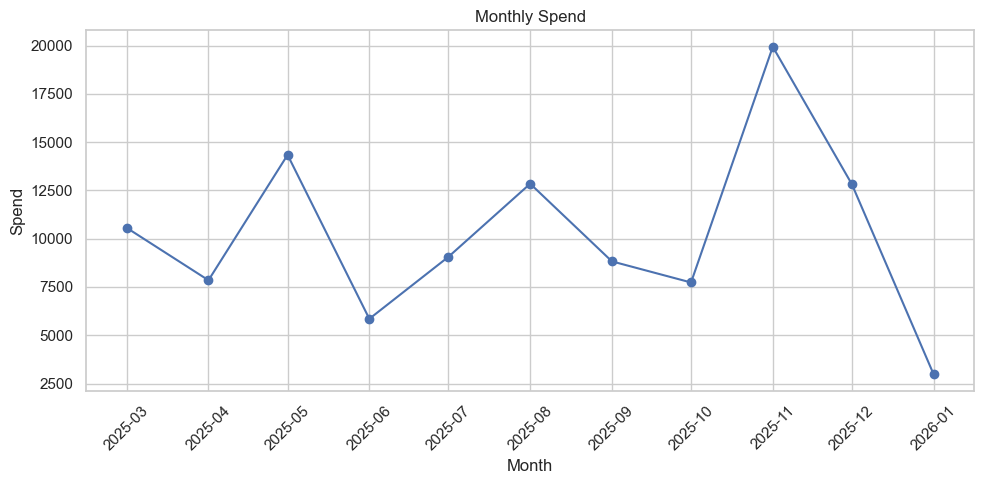

In [37]:
plt.figure()
plt.plot(monthly["month_start"], monthly["spend"], marker="o")
plt.title("Monthly Spend")
plt.xlabel("Month")
plt.ylabel("Spend")
plt.xticks(rotation=45)
plt.tight_layout()

## Category Breakdown

In [38]:
category_total = (
    expenses.groupby("category", as_index=False)["spend"].sum()
    .sort_values("spend", ascending=False)
)

category_total.head(10)

,category,spend
12,travel/transport,28400.72
3,food & bev,28179.62
10,rental inc,14782.44
6,int/bank chg/tax,7139.39
0,auto/local trans,6605.88
7,investment,5311.01
1,business,4313.07
11,supplies/services,4228.44
9,recreation/educ,3952.97
14,utilities,3752.16


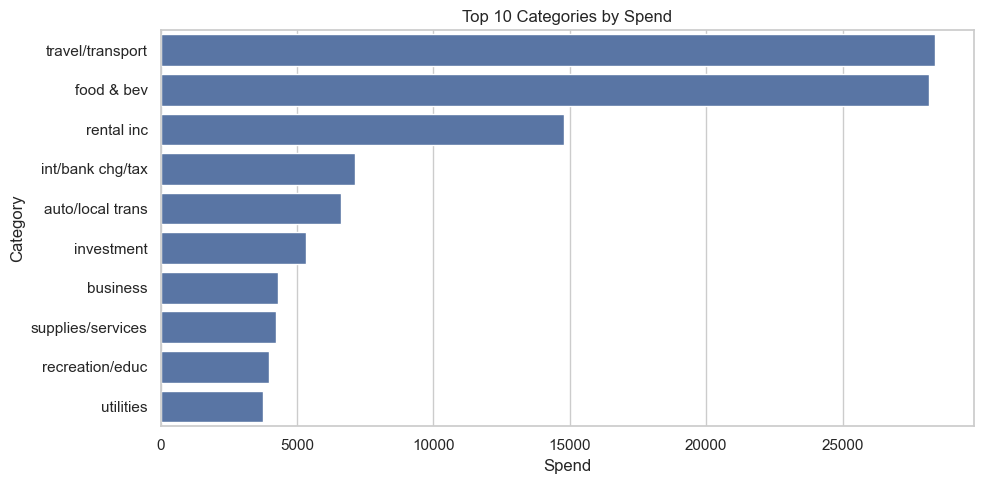

In [39]:
plt.figure()
sns.barplot(data=category_total.head(10), x="spend", y="category")
plt.title("Top 10 Categories by Spend")
plt.xlabel("Spend")
plt.ylabel("Category")
plt.tight_layout()

### Category Share by Month

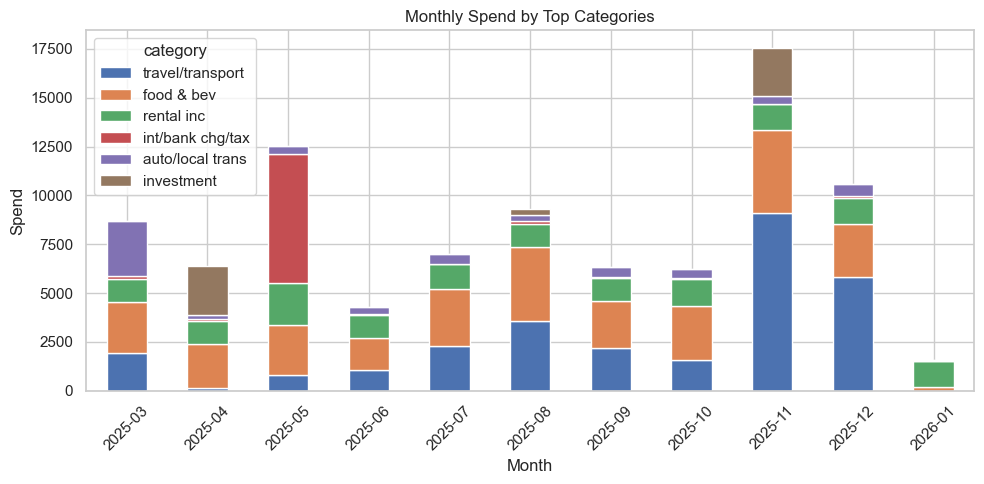

In [40]:
category_month = (
    expenses.groupby(["month_start", "category"], as_index=False)["spend"].sum()
)

pivot = category_month.pivot(index="month_start", columns="category", values="spend").fillna(0)

# Limit to top categories for readability
top_cats = category_total.head(6)["category"].tolist()

pivot_top = pivot[top_cats].copy()
# Use string month labels to avoid Period/Datetime freq issues in plotting
pivot_top.index = pivot_top.index.to_period("M").astype(str)

pivot_top.plot(kind="bar", stacked=True)
plt.title("Monthly Spend by Top Categories")
plt.xlabel("Month")
plt.ylabel("Spend")
plt.xticks(rotation=45)
plt.tight_layout()

## Notable Findings

In [41]:
# Top months
max_month = monthly.loc[monthly["spend"].idxmax()]
min_month = monthly.loc[monthly["spend"].idxmin()]

# Largest MoM increase
mom_inc = monthly.loc[monthly["mom_change"].idxmax()] if monthly["mom_change"].notna().any() else None

insights = {
    "top_month": f"{max_month['month_start'].date()} (${max_month['spend']:.2f})",
    "lowest_month": f"{min_month['month_start'].date()} (${min_month['spend']:.2f})",
}

if mom_inc is not None:
    insights["largest_mom_increase"] = f"{mom_inc['month_start'].date()} (+${mom_inc['mom_change']:.2f})"

insights

{'top_month': '2025-11-01 ($19933.20)',
 'lowest_month': '2026-01-01 ($2974.65)',
 'largest_mom_increase': '2025-11-01 (+$12201.63)'}